In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

seed = 2023
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.experimental.numpy.random.seed(seed)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
from utils_compare_methods import *
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import vedo
import vedo.dolfin as vdf
from prepare_data import rotate, outside_ball
import pandas as pd

sns.set_theme()
sns.set_context("paper")
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)


Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
nb_data = 1500
save_figs = True

small_data = False
level = 2
data = DataLoader(small_data)
agent = Agent(data, small_data)

if not (os.path.exists(f"./images_{nb_data}/")) and save_figs:
    os.makedirs(f"./images_{nb_data}/")

epochs = [50, 100, 200, 400, 500, 1000, 1500, 2000]
print(len(epochs))
print(epochs)

indices = list(range(0, len(epochs)))
size_per_fig = 4
nb_rows = 2
size_row = int(len(indices) / nb_rows)


max_norm_F : 65.79521
data_size,nb_val,nb_train: 1500 187 1313
data shape: (None, 64, 64, 8)
on val data: residues_interior =  7.424501e-05
modèle FNO2d crée avec comme hyperparamètre: modes:20, width:20, pad_prop:0.05 
8
[50, 100, 200, 400, 500, 1000, 1500, 2000]


In [3]:
def new_create_FG_numpy(nb_data, nb_vert):
    xy = np.linspace(0.0, 1.0, nb_vert)
    XX, YY = np.meshgrid(xy, xy)
    XX = np.reshape(XX, [-1])
    YY = np.reshape(YY, [-1])
    XXYY = np.stack([XX, YY])

    mu0 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    mu1 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    sigma = np.random.uniform(0.15, 0.45, size=[nb_data, 1])

    alpha = np.random.uniform(-0.8, 0.8, size=[nb_data, 1])
    beta = np.random.uniform(-0.8, 0.8, size=[nb_data, 1])

    x_0 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    y_0 = np.random.uniform(0.2, 0.8, size=[nb_data, 1])
    lx = np.random.uniform(0.2, 0.45, size=[nb_data, 1])
    ly = np.random.uniform(0.2, 0.45, size=[nb_data, 1])
    theta = np.random.uniform(0.0, 0.6, size=[nb_data, 1])
    check_data = 0
    for n in range(nb_data):
        new_generation = 0
        xx_0, yy_0, llx, lly = x_0[n][0], y_0[n][0], lx[n][0], ly[n][0]
        xx0_llxp = rotate([xx_0, yy_0], [xx_0 + llx, yy_0], theta[n])
        xx0_llxm = rotate([xx_0, yy_0], [xx_0 - llx, yy_0], theta[n])
        yy0_llyp = rotate([xx_0, yy_0], [xx_0, yy_0 + lly], theta[n])
        yy0_llym = rotate([xx_0, yy_0], [xx_0, yy_0 - lly], theta[n])
        while (
            (outside_ball(xx0_llxp))
            or (outside_ball(xx0_llxm))
            or (outside_ball(yy0_llyp))
            or (outside_ball(yy0_llym))
        ):
            x_0[n][0] = np.random.uniform(0.2, 0.8, size=[1, 1])[0]
            y_0[n][0] = np.random.uniform(0.2, 0.8, size=[1, 1])[0]
            lx[n][0] = np.random.uniform(0.2, 0.45, size=[1, 1])[0]
            ly[n][0] = np.random.uniform(0.2, 0.45, size=[1, 1])[0]
            xx_0, yy_0, llx, lly = x_0[n][0], y_0[n][0], lx[n][0], ly[n][0]
            xx0_llxp = rotate([xx_0, yy_0], [xx_0 + llx, yy_0], theta[n])
            xx0_llxm = rotate([xx_0, yy_0], [xx_0 - llx, yy_0], theta[n])
            yy0_llyp = rotate([xx_0, yy_0], [xx_0, yy_0 + lly], theta[n])
            yy0_llym = rotate([xx_0, yy_0], [xx_0, yy_0 - lly], theta[n])
            new_generation += 1
        check_data += 1

    for n in range(nb_data):
        new_generation = 0
        xx_0, yy_0, llx, lly, ttheta = (
            x_0[n][0],
            y_0[n][0],
            lx[n][0],
            ly[n][0],
            theta[n][0],
        )
        mmu0, mmu1 = mu0[n][0], mu1[n][0]
        sigma[n][0] = np.random.uniform(min(llx, lly) / 2.0, max(llx, lly))
        while eval_phi(np, mmu0, mmu1, xx_0, yy_0, llx, lly, ttheta) > -0.15:
            mu0[n][0] = np.random.uniform(0.2, 0.8, size=[1, 1])[0]
            mu1[n][0] = np.random.uniform(0.2, 0.8, size=[1, 1])[0]
            mmu0, mmu1 = mu0[n][0], mu1[n][0]

        check_data += 1

    F = call_F(np, XXYY, mu0, mu1, sigma)
    F = np.reshape(F, [nb_data, nb_vert, nb_vert])

    phi = call_phi(np, XXYY, x_0, y_0, lx, ly, theta)
    phi = np.reshape(phi, [nb_data, nb_vert, nb_vert])

    G = call_G(np, XXYY, alpha, beta)
    G = np.reshape(G, [nb_data, nb_vert, nb_vert])

    params = np.concatenate(
        [mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta], axis=1
    )
    return F, phi, G, params


In [4]:
nb_epochs = 2000
agent.model.load_weights(f"./models_{nb_data}/model_{nb_epochs}/model_weights")


In [5]:
def change_size_fno(param, sizes, Plot=False, nb_epochs=2000):
    u_ex, V_ex, dx_ex = compute_standard_fem(64, param, True)
    errors, sols = [], []
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = param

    agent.model.load_weights(
        f"./models_{nb_data}/model_{nb_epochs}/model_weights"
    )

    for size in sizes:
        print(f"{size=}")
        phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, size)
        F = generate_F_numpy(mu0, mu1, sigma, size) / data.max_norm_F
        G = generate_G_numpy(alpha, beta, size)
        X = generate_manual_new_data_numpy(phi, F, G)
        start_call = time.time()
        Y = agent.model.call(X)
        end_call = time.time()
        temps_fno = end_call - start_call
        solution_predite = X[:, :, :, 1] * Y[:, :, :, 0] + X[:, :, :, 2]
        solution_predite = np.reshape(solution_predite, (size, size))
        sol_predite_fenics = convert_numpy_matrix_to_fenics(
            solution_predite, size, 1
        )
        sol_predite_fenics_proj_V_ex = df.project(
            sol_predite_fenics,
            V_ex,
            # solver_type="gmres",
            # preconditioner_type="hypre_amg",
        )
        sols.append(sol_predite_fenics_proj_V_ex)
        l2_error_fno = (
            df.assemble((((u_ex - sol_predite_fenics_proj_V_ex)) ** 2) * dx_ex)
            ** (0.5)
        ) / (df.assemble((((u_ex)) ** 2) * dx_ex) ** (0.5))
        errors.append(l2_error_fno)

        if Plot:
            plt.figure(figsize=(20, 5.5))
            plt.subplot(1, 4, 1)
            p = df.plot(u_ex, mode="color", cmap=my_cmap)
            plt.colorbar(p)
            plt.title("Exact solution", fontsize="14")
            for i in range(1, 4):
                plt.subplot(1, 4, i + 1)
                p = df.plot(sols[i - 1], mode="color", cmap=my_cmap)
                plt.colorbar(p)
                plt.title(
                    "FNO prediction for nb_vert = "
                    + str(sizes[i - 1])
                    + "\n$L^2$ relative error : "
                    + f"{errors[i-1]}",
                    fontsize="14",
                )

            plt.tight_layout()
            if Plot and save_figs:
                plt.savefig(f"./images_{nb_data}/change_sizes.png")
            plt.show()

    return errors


In [6]:
errors = []
nb_params_to_test = 100
F, phi, G, params = new_create_FG_numpy(nb_params_to_test, 64)
sizes = [48, 64, 80, 100, 120, 200]
print(f"{len(sizes)=}")
for i in range(np.shape(params)[0]):
    print(f"Param : {i+1}/{np.shape(params)[0]}")
    param = params[i]
    error = change_size_fno(param, sizes, Plot=False)
    errors.append(error)
errors = np.array(errors)


len(sizes)=6
Param : 1/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.39319298  0.72682552  0.17974054  0.39034756  0.4871882   0.28601861
  0.32884805  0.43410995 -0.62655892  0.68055809]
Solving linear variational problem.
size=48
size=64
size=80
size=100
size=120
size=200
Param : 2/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.73425347  0.51143837  0.21025697  0.52670825  0.44398343  0.39569229
  0.3739559   0.19894767  0.45950746 -0.13600575]
Solving linear variational problem.
size=48
size=64
size=80
size=100
size=120
size=200
Param : 3/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [0.55283135 0.60829806 0.25219354 0.51161827 0.39912867 0.20417092
 0.27739458 0.27917944 0.5122684  0.40841907]
Solving linear variational problem.
size=48
size=64
size=80
size=100
size=120
size=200
Param : 4/100
(mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta) = [ 0.27595766  0.46133483  0.18224217  0.35280571  0.47150246  0.2344631
  0.342

In [ ]:
plt.figure(figsize=(8, 8))

for i in range(np.shape(errors)[1]):
    sns.histplot(
        data=errors[:, i],
        kde=True,
        bins=20,
        edgecolor="k",
        log_scale=True,
        label=f"FNO nb_vert = {sizes[i]}",
        stat="proportion",
        legend=True,
    )
# plt.xlim(1e-4, 1e0)
# plt.ylim(0.0, 0.30)
plt.xlabel("$L^2$ relative error")
plt.legend()

plt.tight_layout()
save_figs = False
if save_figs:
    plt.savefig(f"./images_{nb_data}/histograms_change_sizes.png")
plt.show()


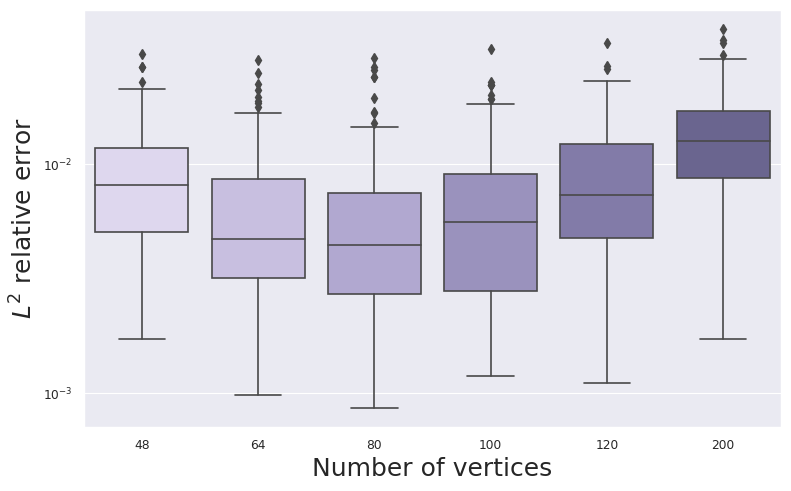

In [8]:
abs_str = sizes
dataframe = pd.DataFrame(errors, columns=abs_str)
save_figs = True
plt.figure(figsize=(8, 5))

sns.boxplot(data=dataframe, palette="ch:s=-.05,rot=0.06,dark=0.4")
plt.yscale("log")
plt.xlabel("Number of vertices", fontsize=18)
plt.ylabel("$L^2$ relative error", fontsize=18)
plt.tight_layout()
if save_figs:
    plt.savefig(f"./images_{nb_data}/boxplots_new_data_change_size.png")
plt.show()

In [149]:
errors = []
nb_params_to_test = 1
F, phi, G, params = new_create_FG_numpy(nb_params_to_test, 64)
sizes = [48, 64, 80, 100, 120, 200]
print(list(params[0]))


[0.4439412433592797, 0.23479457571426748, 0.18502604808516293, 0.4269778246511294, 0.38318218846540775, 0.22505303839555765, 0.3166968456589764, 0.4399950623600646, 0.7068648922571581, -0.47021007614606297]


In [9]:
domains = []
solutions = []
for size in sizes:
    i = 0
    print(f"Param : {i+1}/{np.shape(params)[0]}")
    mu0, mu1, sigma, x_0, y_0, lx, ly, theta, alpha, beta = (
        0.30122539,
        0.29640635,
        0.25481616,
        0.46192393,
        0.48159562,
        0.37990447,
        0.32648597,
        0.41180092,
        0.37976006,
        -0.31339751,
    )
    phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, size)
    F = generate_F_numpy(mu0, mu1, sigma, size) / data.max_norm_F
    G = generate_G_numpy(alpha, beta, size)
    X = generate_manual_new_data_numpy(phi, F, G)
    start_call = time.time()
    Y = agent.model.call(X)
    end_call = time.time()
    temps_fno = end_call - start_call
    solution_predite = X[0, :, :, 1] * Y[0, :, :, 0] + X[0, :, :, 2]
    solutions.append(solution_predite)
    domains.append(X[:, :, :, -1])

Param : 1/100
Param : 1/100
Param : 1/100
Param : 1/100
Param : 1/100
Param : 1/100


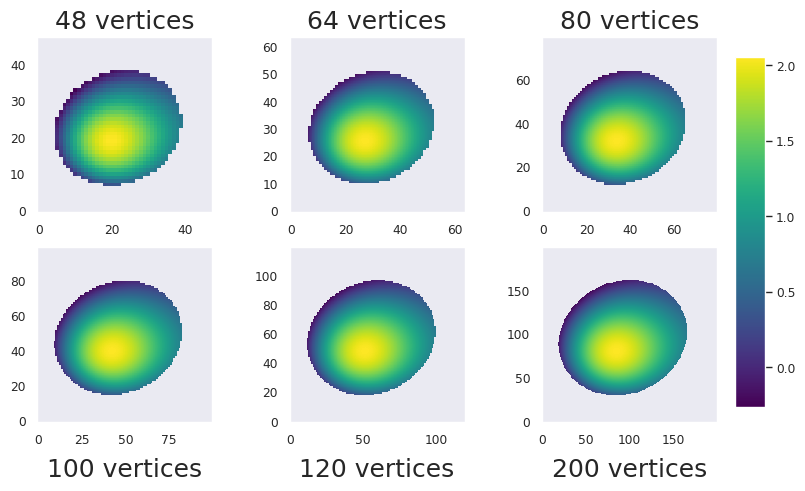

In [10]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=2, ncols=3)
i = 0
for ax in axes.flat:
    domains_nan = domains[i].numpy()
    domains_nan[domains_nan == 0] = np.nan
    im = ax.imshow(
        (domains_nan * solutions[i])[0, :, :], cmap="viridis", origin="lower"
    )
    if i < 3:
        ax.set_title(f"{sizes[i]} vertices", fontsize=18)
    else:
        ax.set_title(f"{sizes[i]} vertices", fontsize=18, y=-0.2, pad=-14)
    ax.grid(False)

    i += 1
fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.84, 0.14, 0.030, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f"./images_{nb_data}/outputs_various_sizes.png")
plt.show()
